# Malaria Skin Classification using Transfer Learning

## Tranfer Learning
Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.
Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:
1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

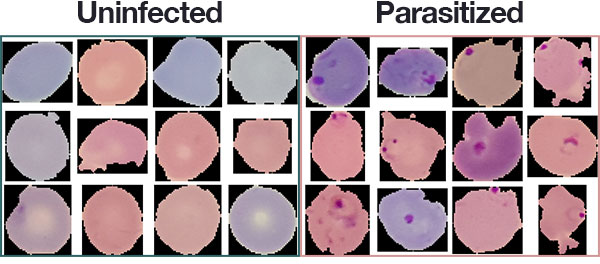

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers 


## Data Loading

In [3]:
train_dir = '../input/cell-images-for-detecting-malaria/cell_images/cell_images/'

In [4]:
parasitized_data = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/')
#print(parasitized_data[:10])

In [5]:
uninfected_data = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected')
#print(uninfected_data[:10])

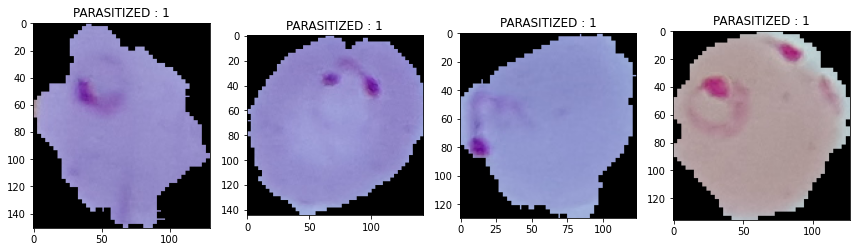

In [6]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/' + "/" + parasitized_data[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()


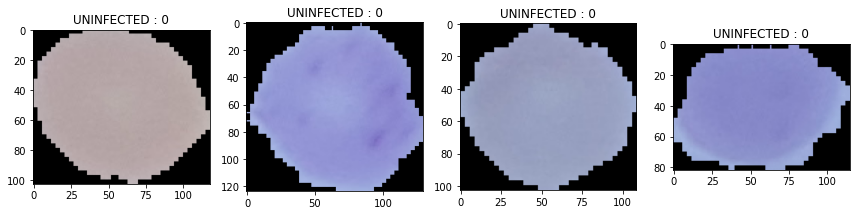

In [7]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected' + "/" + uninfected_data[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

In [8]:
BATCH_SIZE = 100
IMG_SHAPE = 224

## Data Processing

In [9]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data_gen = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle = True,
                                              target_size = (IMG_SHAPE, IMG_SHAPE),
                                              subset='training')
valid_data_gen = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle = True,
                                              target_size = (IMG_SHAPE, IMG_SHAPE),
                                              subset='validation')

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [10]:
train_data_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

## Creating Model

VGG16 is a pre-trained model that takes in (224,224) RGB images and converts them into features.The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories. The images were collected from the web and labeled by human labelers using Amazon’s Mechanical Turk crowd-sourcing tool.

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
                  include_top = False,
                  weights = 'imagenet')

58892288/58889256 [==============================] - 0s 0us/step


## Model Achitecture of VGG16

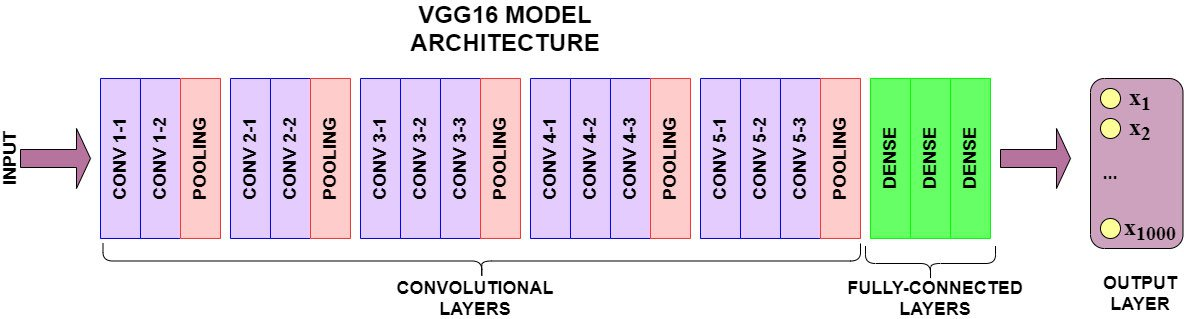

So, Here we are not including top layer as it gives 1000 outputs. We are doing binary classification. So we will include our Fully connected layer which contains only 2 output.

### Freezing the layers

In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='sigmoid')(x)



In [14]:
model = tf.keras.models.Model(base_model.input, x)

In [15]:
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Training

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
his = model.fit(train_data_gen, validation_data= valid_data_gen, steps_per_epoch = BATCH_SIZE, epochs = 5, callbacks=callback)

Epoch 1/5
100/100 [==============================] - 120s 1s/step - loss: 1.3335 - accuracy: 0.6506 - val_loss: 0.3722 - val_accuracy: 0.8597
Epoch 2/5
100/100 [==============================] - 71s 712ms/step - loss: 0.3676 - accuracy: 0.8466 - val_loss: 0.2804 - val_accuracy: 0.9005
Epoch 3/5
100/100 [==============================] - 58s 580ms/step - loss: 0.3050 - accuracy: 0.8814 - val_loss: 0.2395 - val_accuracy: 0.9033
Epoch 4/5
100/100 [==============================] - 53s 530ms/step - loss: 0.2737 - accuracy: 0.9022 - val_loss: 0.2513 - val_accuracy: 0.9064
Epoch 5/5
100/100 [==============================] - 50s 503ms/step - loss: 0.2522 - accuracy: 0.9005 - val_loss: 0.2322 - val_accuracy: 0.9140


## Model Performance

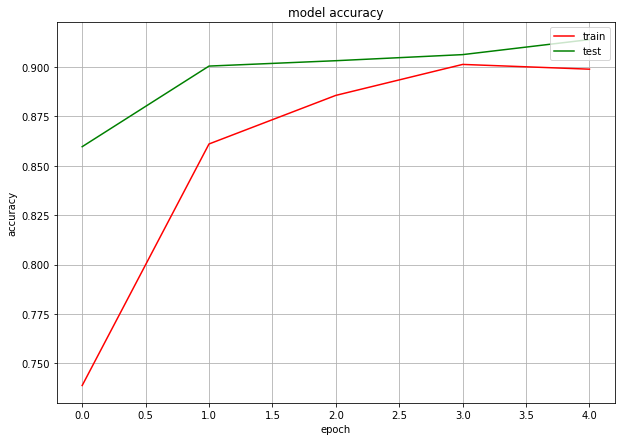

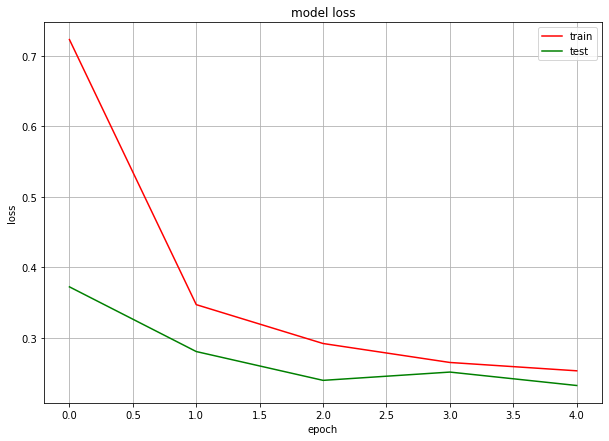

In [18]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=True)
ax.plot(his.history['accuracy'], color='red')
ax.plot(his.history['val_accuracy'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=True)
ax.plot(his.history['loss'], color='red')
ax.plot(his.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


Our model is performing well.

In [19]:
model.save('my_model.h5')


## Prediction
Testing with our own Image

In [20]:
test_image = r"../input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png"

Parasitic


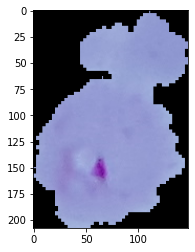

In [21]:
from keras.preprocessing import image
def load(filename):
    img = cv2.imread(filename)
    plt.imshow(img)
    img = image.load_img(test_image, target_size = (IMG_SHAPE, IMG_SHAPE))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    index = model.predict(img)
    index = index.argmax().item()
    if index == 0:
        return "Parasitic"
    elif img == 1:
        return "Non-Parasitic"
    else :
        return
    
image = load(test_image)
print(image)
#model.predict(image)

In [22]:
#### if you like this notebook, please upvote, it motivates me a lot!
#### if you have any suggestion to improve this notebook please comment! 